In [1]:
import logging
import torch
import data
import os
import numpy as np

from models import imagebind_model
from models.imagebind_model import ModalityType, load_module
from models import lora as LoRA

from models.pc_ae_net import PointcloudAutoencoder
from utils.latent_ops import slerp

logging.basicConfig(level=logging.INFO, force=True)

lora = False
linear_probing = False
device = "cuda:2"  # "cuda:0" if torch.cuda.is_available() else "cpu"
torch.cuda.set_device(device)
load_head_post_proc_finetuned = True

decoder_path = '/root/volume/.checkpoints/decoder/changeit3m-epoch=347-val_loss=0.00.ckpt/checkpoint/mp_rank_00_model_states.pt'
cls = ['airplane', 'bench', 'table', 'lamp', 'chair']
sample = 2

top_img_dir = 'images/full_size/'
shapetalk_file = 'language/shapetalk_raw_public_version_0.csv'
top_shape_dir = 'point_clouds/scaled_to_align_rendering/'

/root/anaconda3/envs/imagebind_LoRA/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/anaconda3/envs/imagebind_LoRA/lib/python3.8/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/root/anaconda3/envs/imagebind_LoRA/lib/python3.8/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


Jitting Chamfer 3D
Loaded JIT 3D CUDA chamfer distance


In [2]:

# breakpoint()
model = imagebind_model.imagebind_huge(pretrained=True, device=device, model_path="/root/volume/.checkpoints/deepspeed_3d_text_full_1024_v1/imagebind-epoch=57-val_loss=1.37.ckpt/checkpoint/mp_rank_00_model_states.pt", deepspeed=True)

model.eval()
model.to(device)

ImageBindModel(
  (modality_preprocessors): ModuleDict(
    (vision): RGBDTPreprocessor(
      (cls_token): tensor((1, 1, 1280), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Sequential(
          (0): PadIm2Video()
          (1): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
        )
      )
      (pos_embedding_helper): SpatioTemporalPosEmbeddingHelper(
        (pos_embed): tensor((1, 257, 1280), requires_grad=True)
        
      )
    )
    (text): TextPreprocessor(
      (pos_embed): tensor((1, 77, 1024), requires_grad=True)
      (mask): tensor((77, 77), requires_grad=False)
      
      (token_embedding): Embedding(49408, 1024)
    )
    (shape): Point3DPreprocessor(
      (cls_token): tensor((1, 1, 384), requires_grad=True)
      (cls_pos): tensor((1, 1, 384), requires_grad=True)
      (dvae): tensor((128,), requires_grad=False)
      (dvae): tensor((128,), requires_grad=False)
      (dvae): tensor((), requires_grad

In [2]:
# get shapes from cls
shape_dir = []
for c in cls:
    shape_dir.append(os.path.join('/root/volume/datasets/shapetalk', top_shape_dir, c))
model_dir = []
for s in shape_dir:
    model_dir.append([os.path.join(s, t) for t in os.listdir(s)])
shape_paths = []
for p in model_dir:
    temp = []
    for m in p:
        temp.extend([os.path.join(m, t) for t in os.listdir(m)])
    shape_paths.append(temp[:sample])

shape_paths = np.array(shape_paths)
print(shape_paths)

shape_paths = shape_paths.reshape((-1,))

shapes = data.load_and_transform_3D(shape_paths, device)

inputs = {
    ModalityType.SHAPE: shapes,
}

[['/root/volume/datasets/shapetalk/point_clouds/scaled_to_align_rendering/airplane/ModelNet/airplane_0101.npz'
  '/root/volume/datasets/shapetalk/point_clouds/scaled_to_align_rendering/airplane/ModelNet/airplane_0700.npz']
 ['/root/volume/datasets/shapetalk/point_clouds/scaled_to_align_rendering/bench/ModelNet/bench_0096.npz'
  '/root/volume/datasets/shapetalk/point_clouds/scaled_to_align_rendering/bench/ModelNet/bench_0103.npz']
 ['/root/volume/datasets/shapetalk/point_clouds/scaled_to_align_rendering/table/ModelNet/table_0399.npz'
  '/root/volume/datasets/shapetalk/point_clouds/scaled_to_align_rendering/table/ModelNet/table_0183.npz']
 ['/root/volume/datasets/shapetalk/point_clouds/scaled_to_align_rendering/lamp/ModelNet/lamp_0111.npz'
  '/root/volume/datasets/shapetalk/point_clouds/scaled_to_align_rendering/lamp/ModelNet/lamp_0078.npz']
 ['/root/volume/datasets/shapetalk/point_clouds/scaled_to_align_rendering/chair/ModelNet/chair_0403.npz'
  '/root/volume/datasets/shapetalk/point_cl

In [25]:

with torch.no_grad():
    embeddings = model(inputs)

embeddings = embeddings['shape']
embeddings = embeddings.reshape((-1, sample, embeddings.shape[-1]))
print(embeddings.shape)

checkpoint = torch.load(decoder_path, map_location=device)
decoder = PointcloudAutoencoder(1024)
# deepspeed.DeepSpeedEngine.load_checkpoint(load_dir=model_path, load_module_only=True)
checkpoint_state_dict = checkpoint['module']

# Then modify the keys
new_state_dict = {key.replace('_forward_module.ae_model.', ''): value for key, value in checkpoint_state_dict.items()}
decoder.load_state_dict(new_state_dict, strict=True)
decoder.to(device)

inter_l = [slerp(embeddings[:, 0], embeddings[:, 1], t) for t in np.arange(0.1, 1., 0.2)]
inter_l = torch.cat(inter_l)

embeddings = torch.cat([embeddings.reshape((-1, embeddings.shape[-1])), inter_l], dim=0)

points = decoder(embeddings)


torch.Size([5, 2, 1024])


Shape of the Point Cloud: torch.Size([35, 4096, 3])


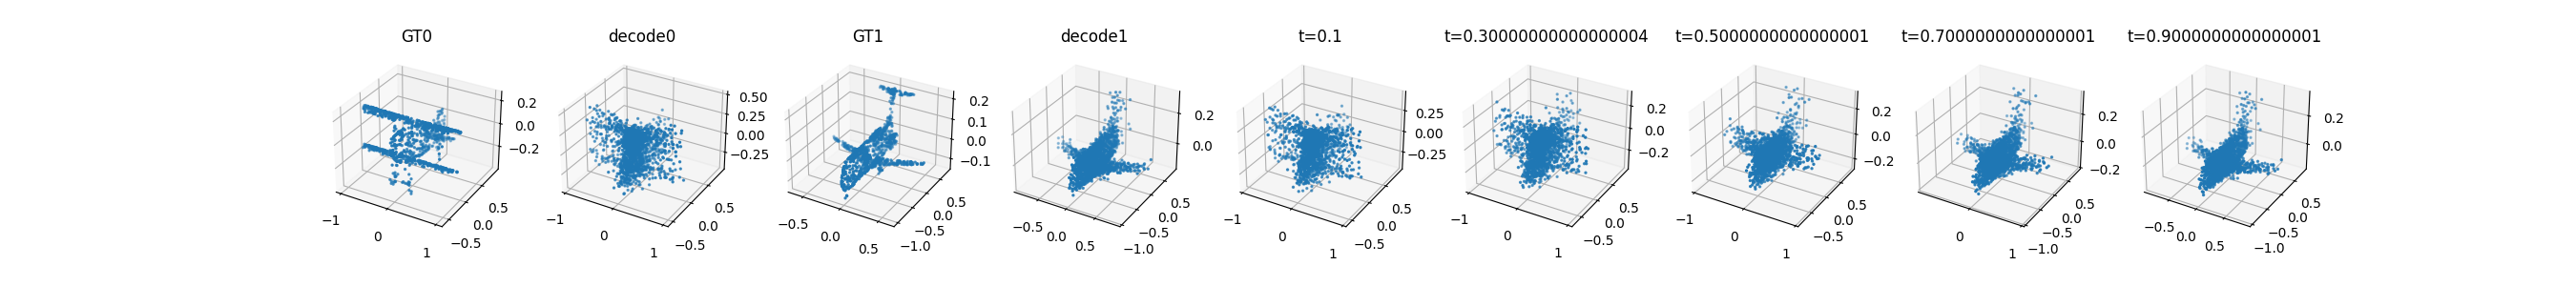

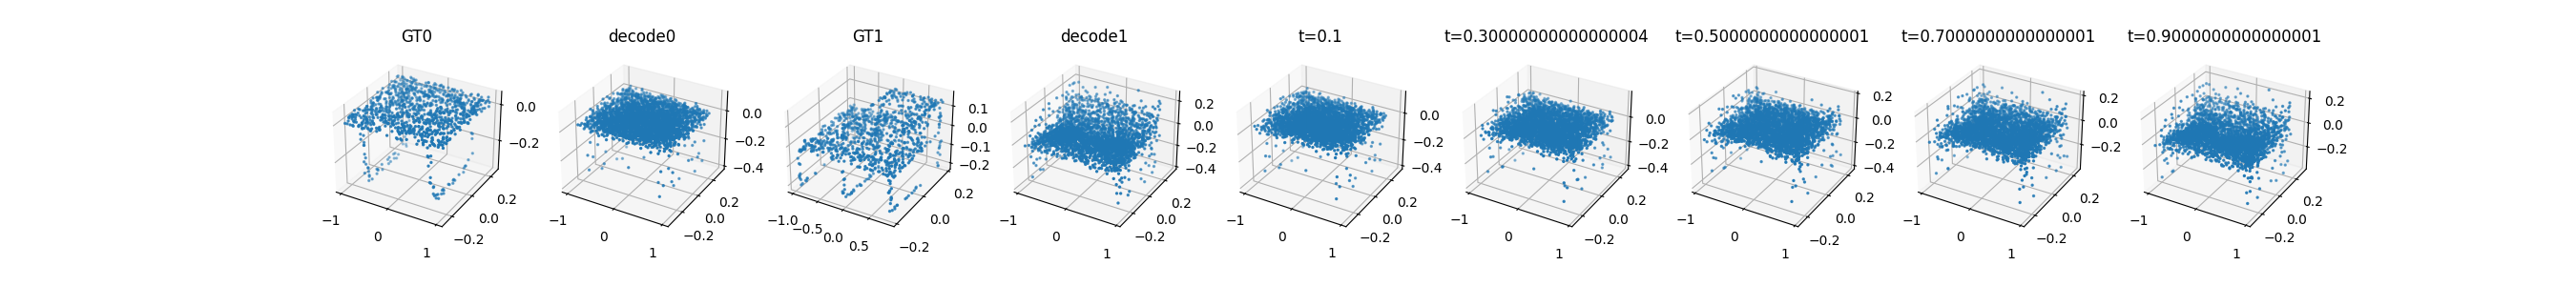

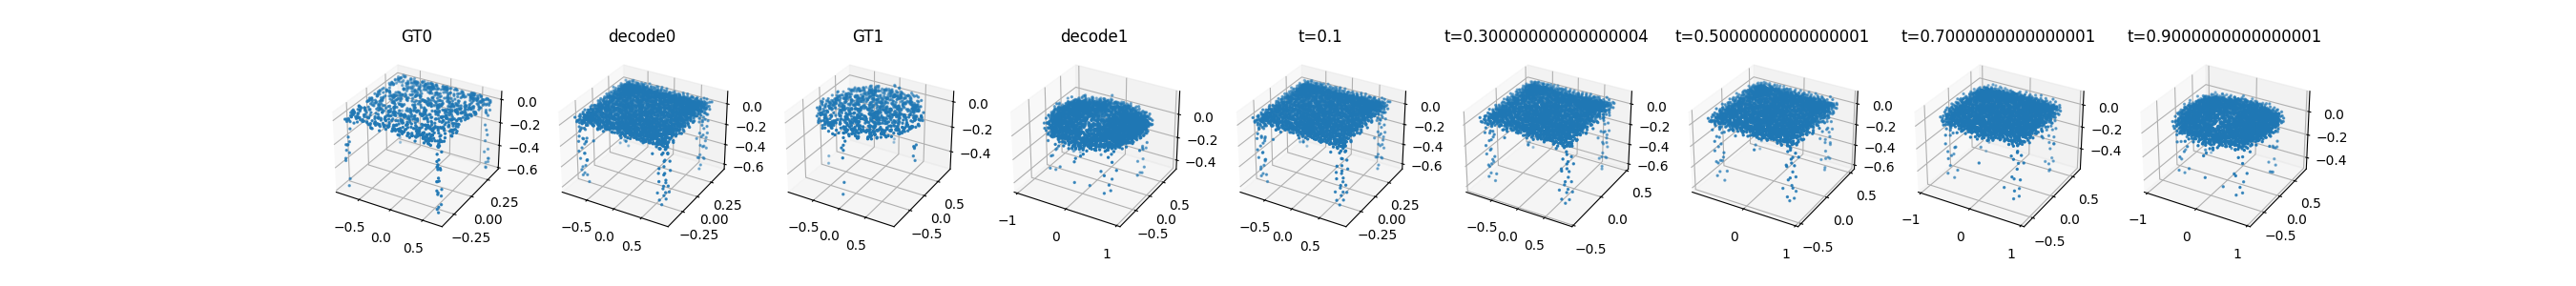

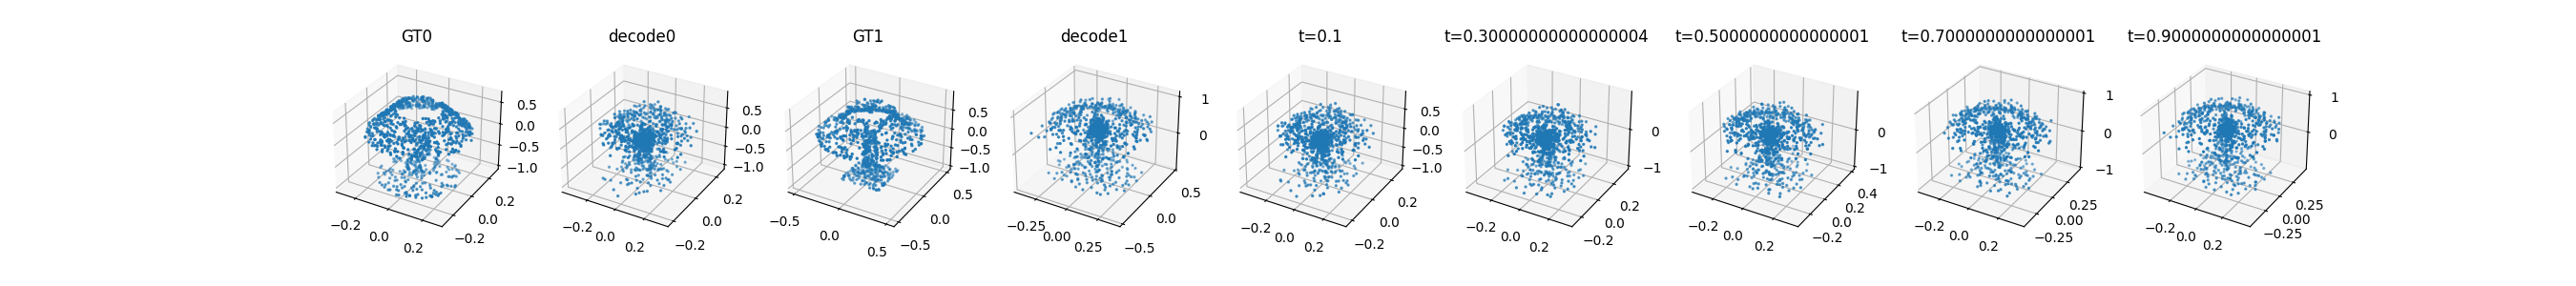

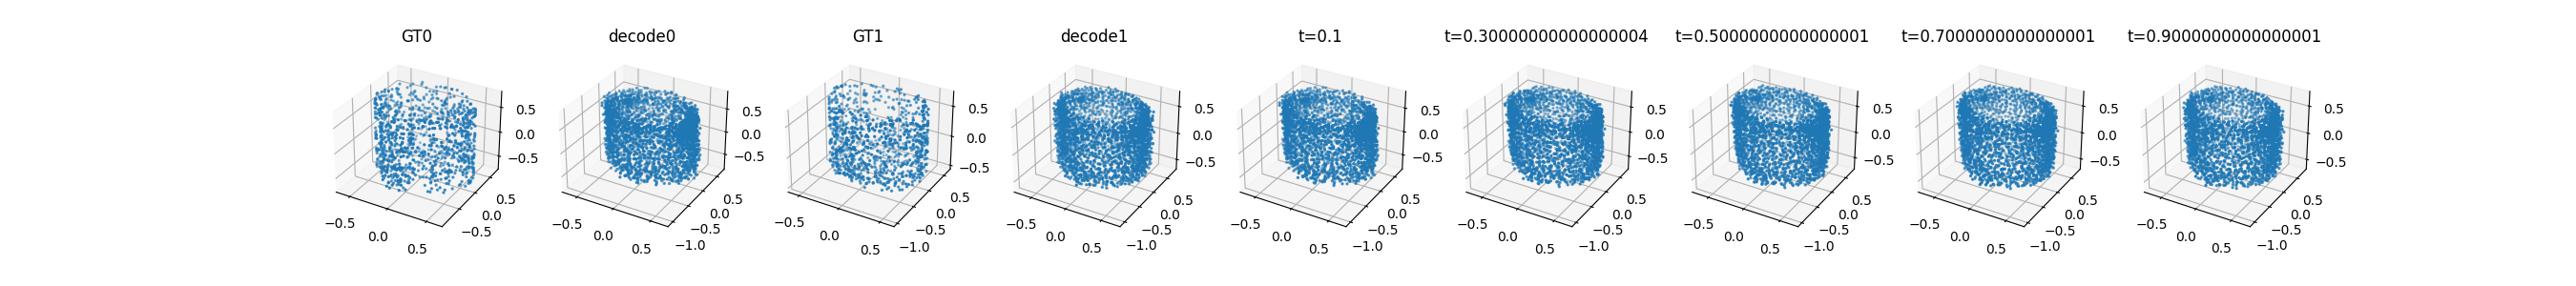

In [26]:
from utils.simple_vis import visualize_point_clouds_3d_v2

print('Shape of the Point Cloud:', points.shape)

shapes = shapes.numpy(force=True)
points = points.numpy(force=True)

shapes = shapes.reshape((-1, sample, shapes.shape[-2], shapes.shape[-1]))
decode = points[:-len(inter_l)]
inter = points[-len(inter_l):]
decode = decode.reshape((-1, 2, decode.shape[-2], decode.shape[-1]))
inter = inter.reshape((-1, 5, inter.shape[-2], inter.shape[-1]))

for i in range(len(shapes)):
    visualize_point_clouds_3d_v2([shapes[i][0], decode[i][0], shapes[i][1], decode[i][1], *inter[:, i]], 
                                title_lst= ['GT0', 'decode0', 'GT1', 'decode1', *[f't={t}' for t in np.arange(0.1, 1., 0.2)]], 
                                vis_axis_order=[0, 2, 1]).show()

Shape of the Point Cloud: torch.Size([35, 4096, 3])


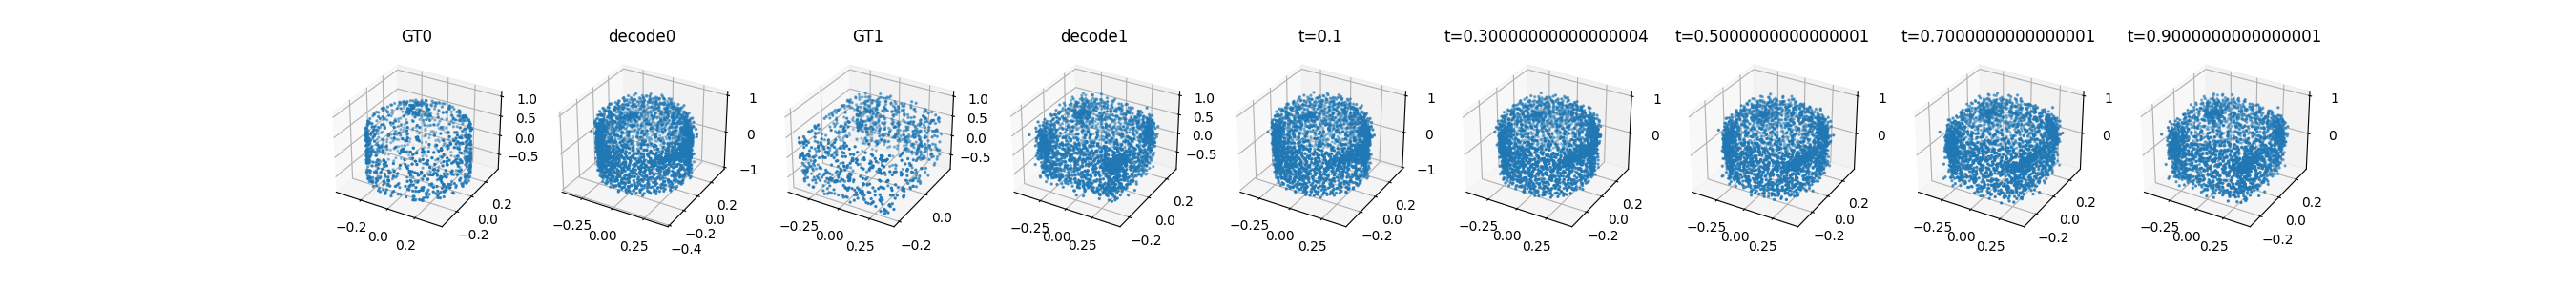

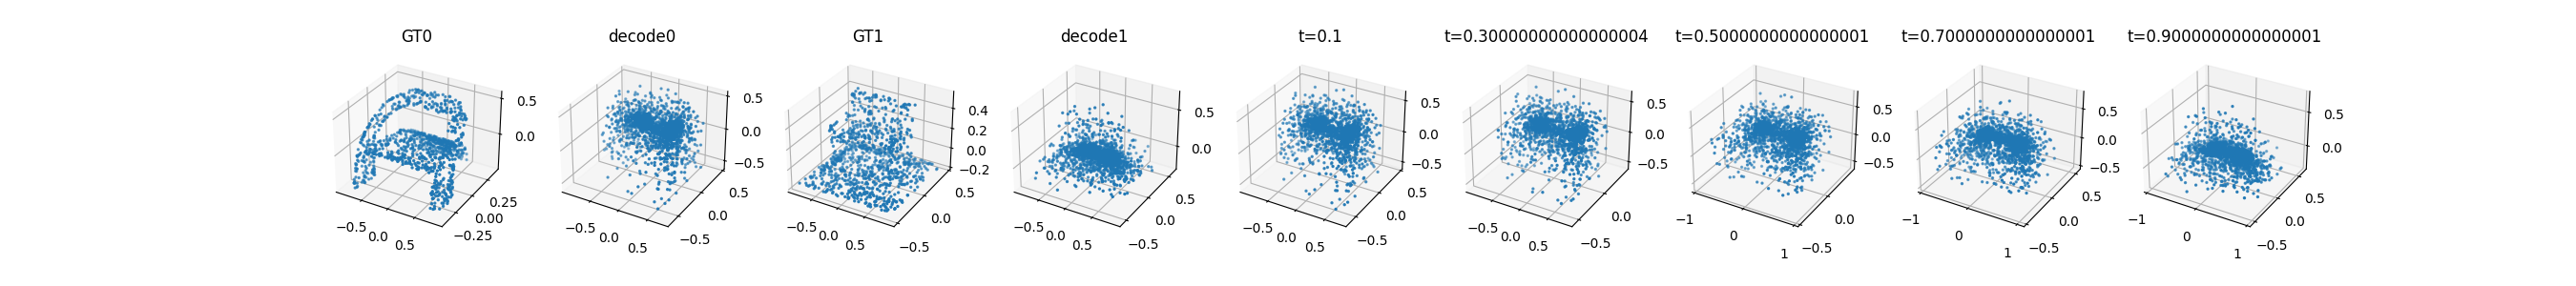

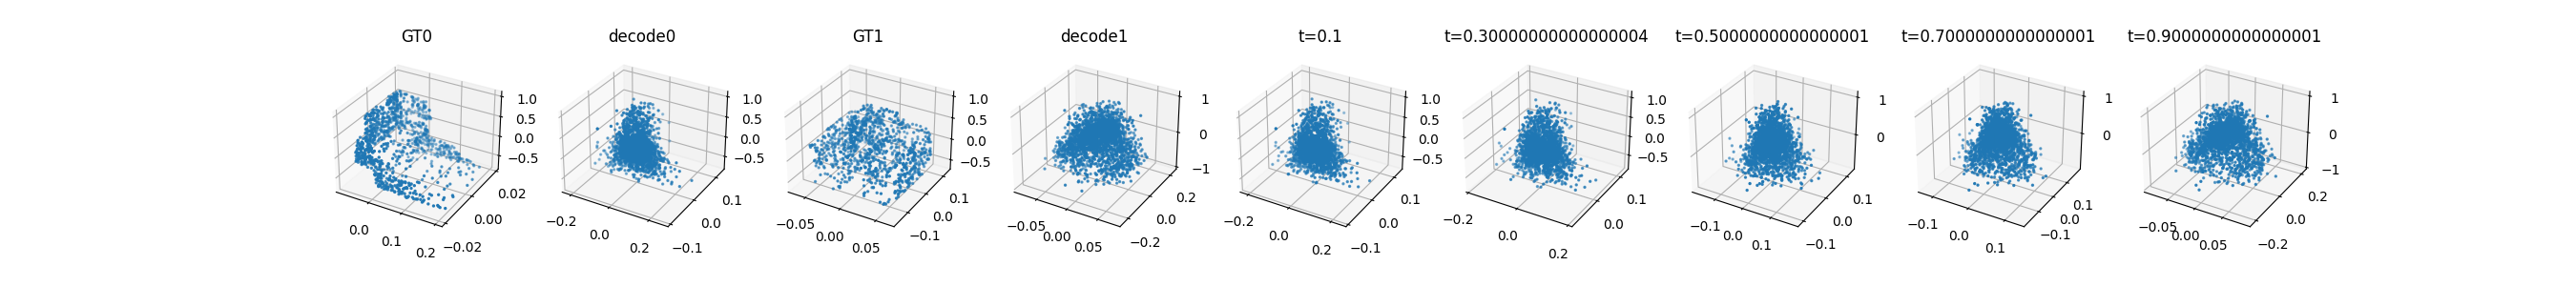

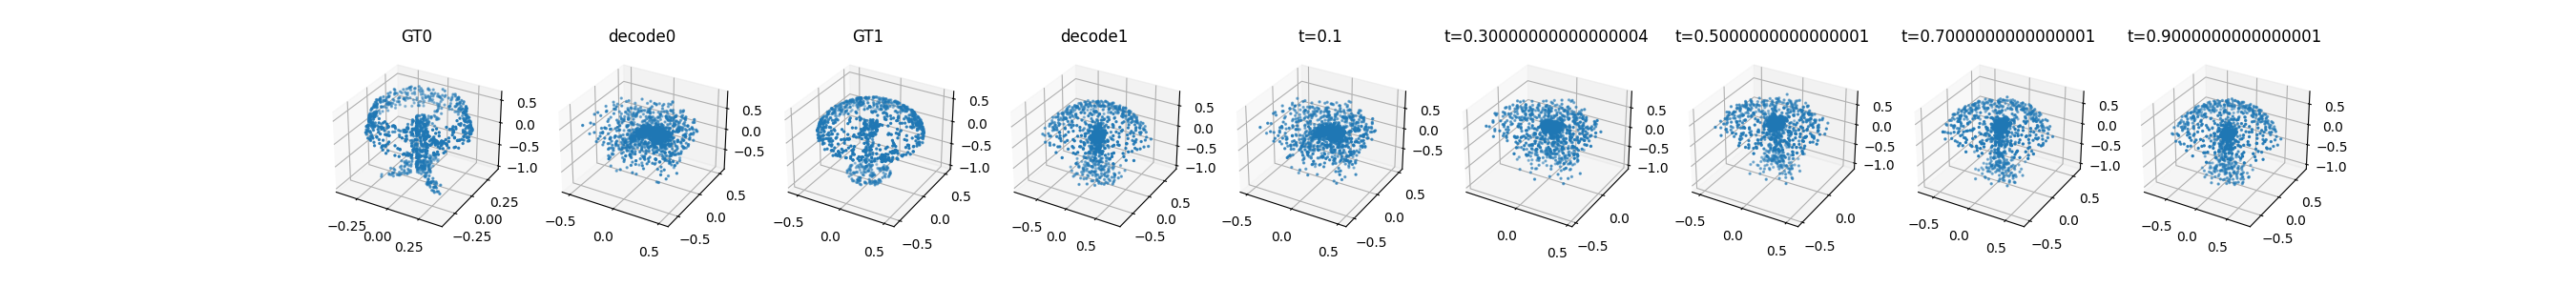

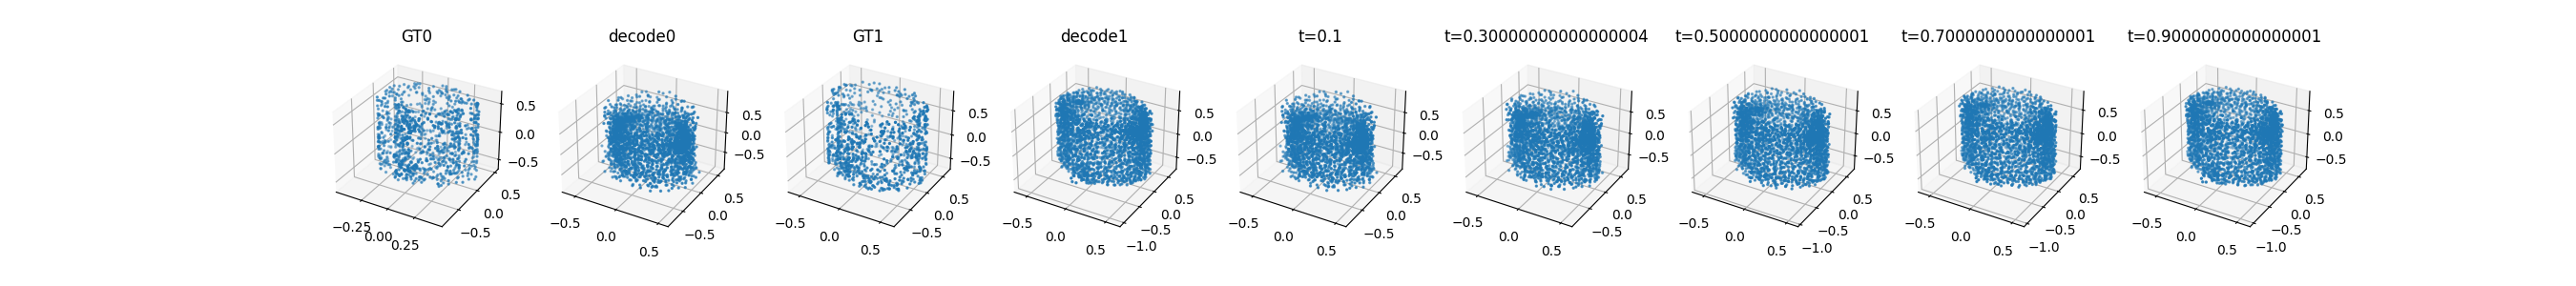

In [12]:
from utils.simple_vis import visualize_point_clouds_3d_v2

print('Shape of the Point Cloud:', points.shape)

shapes = shapes.numpy(force=True)
points = points.numpy(force=True)

shapes = shapes.reshape((-1, sample, shapes.shape[-2], shapes.shape[-1]))
decode = points[:-len(inter_l)]
inter = points[-len(inter_l):]
decode = decode.reshape((-1, 2, decode.shape[-2], decode.shape[-1]))
inter = inter.reshape((-1, 5, inter.shape[-2], inter.shape[-1]))

for i in range(len(shapes)):
    visualize_point_clouds_3d_v2([shapes[i][0], decode[i][0], shapes[i][1], decode[i][1], *inter[:, i]], 
                                title_lst= ['GT0', 'decode0', 'GT1', 'decode1', *[f't={t}' for t in np.arange(0.1, 1., 0.2)]], 
                                vis_axis_order=[0, 2, 1]).show()

Shape of the Point Cloud: (35, 4096, 3)


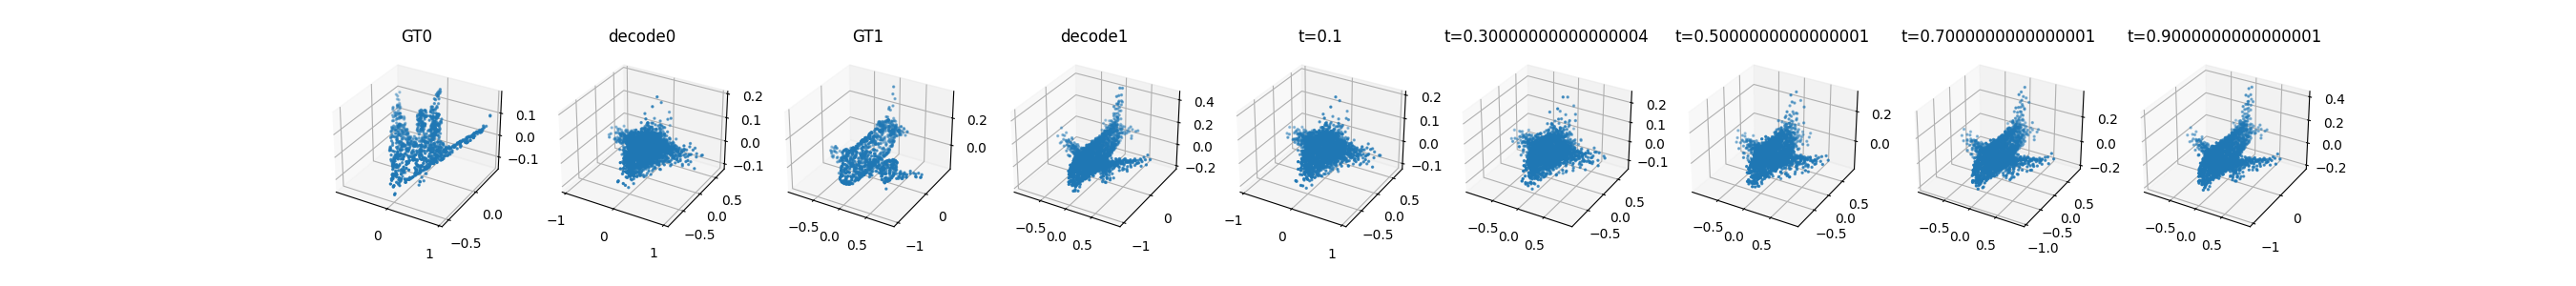

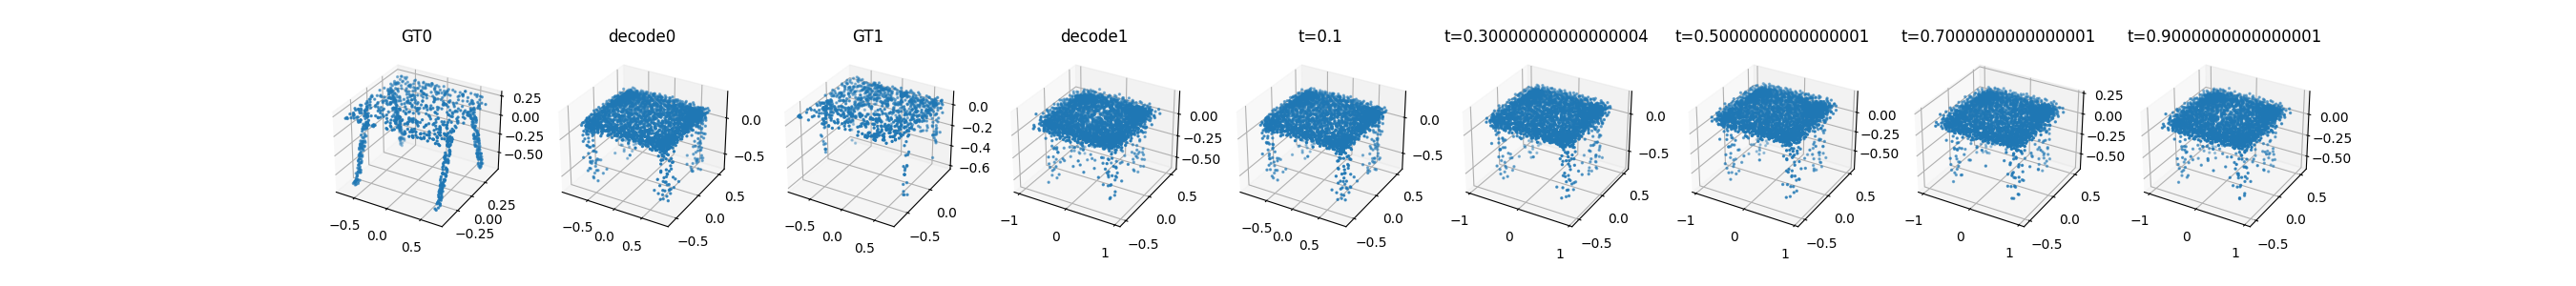

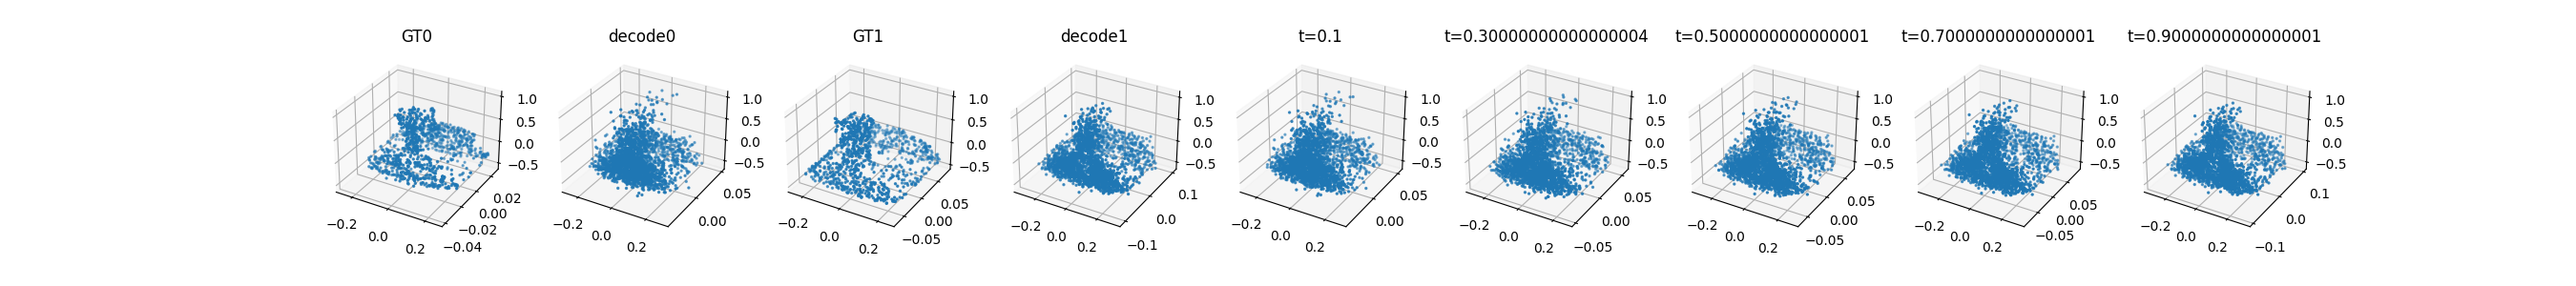

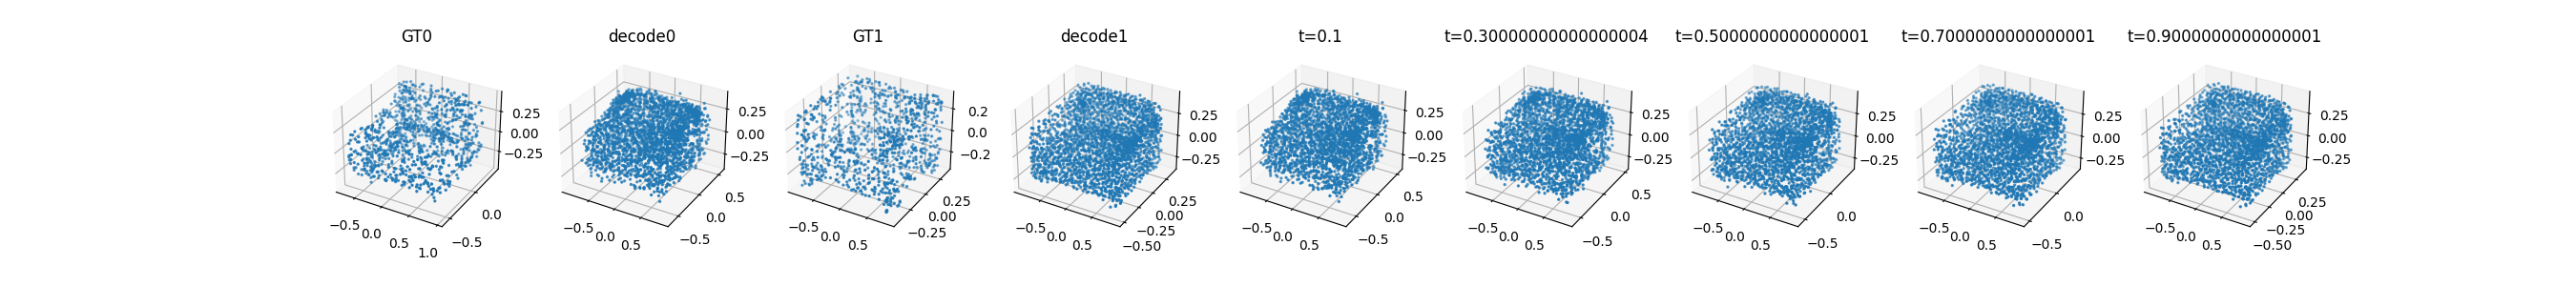

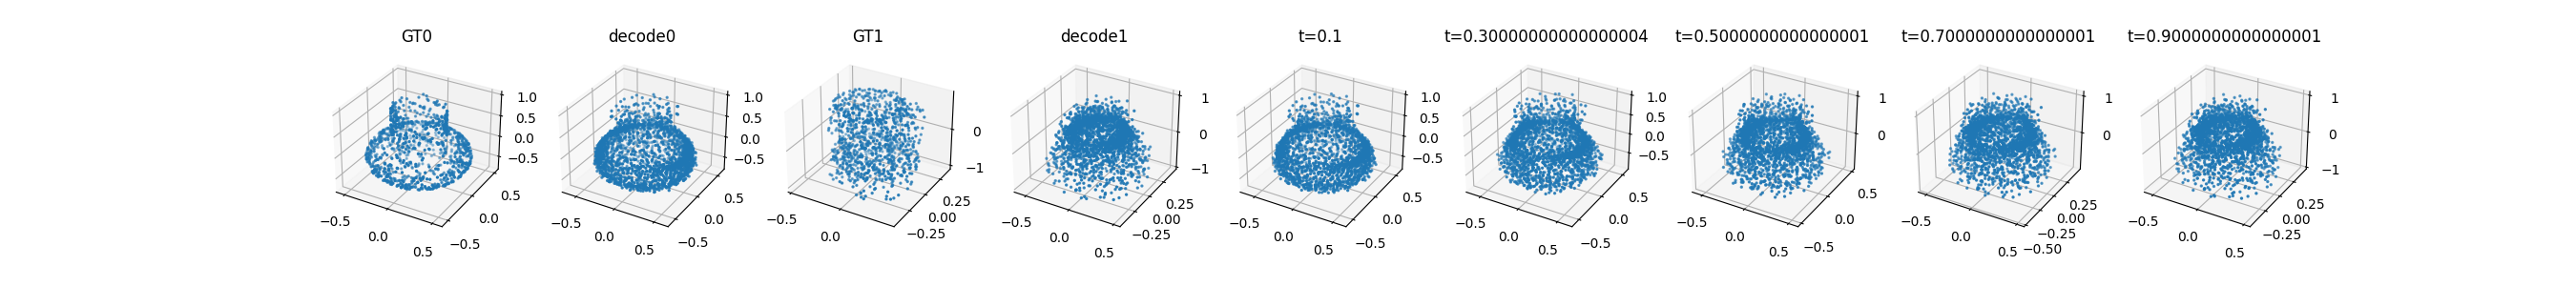

In [7]:
from utils.simple_vis import visualize_point_clouds_3d_v2

print('Shape of the Point Cloud:', points.shape)

# shapes = shapes.numpy(force=True)
# points = points.numpy(force=True)

shapes = shapes.reshape((-1, sample, shapes.shape[-2], shapes.shape[-1]))
decode = points[:-len(inter_l)]
inter = points[-len(inter_l):]
decode = decode.reshape((-1, 2, decode.shape[-2], decode.shape[-1]))
inter = inter.reshape((-1, 5, inter.shape[-2], inter.shape[-1]))

for i in range(len(shapes)):
    visualize_point_clouds_3d_v2([shapes[i][0], decode[i][0], shapes[i][1], decode[i][1], *inter[:, i]], 
                                title_lst= ['GT0', 'decode0', 'GT1', 'decode1', *[f't={t}' for t in np.arange(0.1, 1., 0.2)]], 
                                vis_axis_order=[0, 2, 1]).show()
